In [1]:
import os

os.chdir("..")

print(os.getcwd())

c:\Users\mquick\Documents\zeitgeist blog\projects\political_fragmentation


In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import GiniCalculator
from typing import Sequence, Any

### Collect elections data from Wikipedia

* Elections from 1824 to 2020
* 2016 is only exception
* Don't need to clean state names / codes

In [3]:
class WikiScraper:
    
    def __init__(self, election_year: int) -> None:
        self.election_year = election_year
        
    def get_tables(self) -> list[pd.DataFrame]:
        url = f"https://en.wikipedia.org/wiki/{self.election_year}_United_States_presidential_election"
        return pd.read_html(url)
    
    def find_state_results_table(self, all_tables: list[pd.DataFrame]) -> pd.DataFrame:
        state_results_index = [
            i 
            for i in range(len(all_tables)) 
            if any(
                [re.search(r"state total|margin", str(col), re.IGNORECASE) 
                 for col in all_tables[i].columns
                 ])
            ]
        if not state_results_index:
            raise Exception
        return all_tables[state_results_index[-1]]
    
    @staticmethod
    def collapse_columns(columns: Sequence[str]) -> list[str]:
        collapsed_cols = []
        for col in columns:
             col = ' '.join(
                 set(
                     [
                         c 
                         for c in col 
                         if not c.startswith("Unnamed") 
                         and "Candidates with" not in c
                         ]
                     )
                 )
             col = col.strip()
             collapsed_cols.append(col)
        return collapsed_cols
    
    @staticmethod
    def get_candidate_names(columns: list[str]) -> list[str]:
        return [
            col.replace("%", "").strip() 
            for col in columns 
            if "%" in col
            and not re.search(r"margin|state", col, re.IGNORECASE)
            ]
        
    @staticmethod
    def get_candidate_results_cols(columns: list[str], candidates: list[str]) -> list[str]:
        return [
            col 
            for col in columns 
            if any([candidate in col for candidate in candidates]) 
            and ("%" in col or ("#" in col or "Vote" in col))
            ]
    
    def clean_df_columns(self, results_df: pd.DataFrame) -> pd.DataFrame:
        results_df.columns = self.collapse_columns(results_df.columns.values)
        candidates = self.get_candidate_names(results_df.columns)
        candidate_results_cols = self.get_candidate_results_cols(results_df.columns, candidates)
        results_df = results_df.rename(columns={results_df.columns[0]: "State"})
        return results_df[["State"] + candidate_results_cols]
    
    @staticmethod
    def clean_numeric_val(value: Any) -> float:
        numeric_val = re.sub(r"[^\d\.]", "", str(value))
        if not numeric_val:
            return 0
        return float(numeric_val)
    
    def clean_df_rows(self, results_df: pd.DataFrame) -> pd.DataFrame:
        results_df = results_df.dropna(subset=["State"])
        results_df = results_df[~results_df["State"].apply(lambda x: bool(re.search(r"total", x, re.IGNORECASE)) or x.isupper())]
        for col in results_df.columns[1:]:
            results_df[col] = results_df[col].apply(self.clean_numeric_val)
        return results_df
    
    def format_results_df(self, results_df: pd.DataFrame) -> pd.DataFrame:
        results_df = results_df.melt(id_vars="State", var_name="variable", value_name="value")
        results_df["result_type"] = results_df["variable"].apply(
            lambda x: 
                "votes_pct" if "%" in x 
                else "votes_total" if ("#" in x or "Vote" in x)
                else np.nan
                )
        if not results_df[results_df["result_type"].isna()].empty:
            raise Exception
        results_df["ticket"] = results_df["variable"].apply(lambda x: re.sub(r"[%#]+|Votes?\s?[cast]*", "", x).strip())
        results_df = results_df\
            .drop("variable", axis=1)\
            .pivot_table(index=["State", "ticket"], columns="result_type", values="value")\
            .reset_index()\
            .rename_axis(None, axis=1)\
            .assign(election_year = self.election_year)
        return results_df[["State", "election_year", "ticket", "votes_pct", "votes_total"]]
        
    def get_state_results(self) -> pd.DataFrame:
        all_tables = self.get_tables()
        raw_results_df = self.find_state_results_table(all_tables)
        clean_cols_df = self.clean_df_columns(raw_results_df)
        clean_df = self.clean_df_rows(clean_cols_df)
        formatted_df = self.format_results_df(clean_df)
        return formatted_df

In [4]:
elections_df = pd.concat([
    WikiScraper(year).get_state_results()
    for year in range(1824, 2024, 4)
    if year != 2016
    ])

In [5]:
elections_df.loc[(elections_df["votes_pct"]>=80) & (elections_df["election_year"]>=1948)]

,State,election_year,ticket,votes_pct,votes_total
128,Mississippi[e][91],1948,J. Strom Thurmond Dixiecrat,87.17,167538.0
92,Mississippi,1964,Barry Goldwater Republican,87.14,356528.0
153,Rhode Island,1964,Lyndon B. Johnson Democratic,80.87,315463.0
58,District of Columbia,2004,John Kerry Democratic,89.18,202970.0
56,District of Columbia,2008,Barack Obama Democratic,92.46,245800.0
40,District of Columbia,2012,Barack Obama Democratic,90.91,267070.0
40,District of Columbia,2020,Biden/Harris Democratic,92.15,317323.0


#### 2016 election results

In [6]:
url = "https://www.fec.gov/documents/1890/federalelections2016.xlsx"

In [7]:
results_2016_df = pd.read_excel(url, sheet_name="Table 2. Electoral &  Pop Vote", header=[2, 3])

In [8]:
results_2016_df.head(3)

STATE ELECTORAL VOTE             POPULAR VOTE              \
  Unnamed: 0_level_1      Trump (R) Clinton (D)    Trump (R) Clinton (D)   
0                 AL              9         NaN    1318255.0    729547.0   
1                 AK              3         NaN     163387.0    116454.0   
2                 AZ             11         NaN    1252401.0   1161167.0   

                         
  All Others Total Vote  
0    75570.0  2123372.0  
1    38767.0   318608.0  
2   159597.0  2573165.0

In [9]:
scraper = WikiScraper(2016)

In [10]:
results_2016_df.columns = scraper.collapse_columns(results_2016_df.columns.values)

In [11]:
clean_results_df = results_2016_df.loc[:50].drop([results_2016_df.columns[i] for i in [1, 2]], axis=1)

In [12]:
melted_df = clean_results_df.melt(id_vars=["STATE", "Total Vote POPULAR VOTE"], var_name="ticket", value_name="votes_total")

In [13]:
melted_df["votes_pct"] = (melted_df["votes_total"] / melted_df["Total Vote POPULAR VOTE"]) * 100

In [14]:
melted_df["ticket"] = melted_df["ticket"].str.replace("POPULAR VOTE", "").str.strip()

In [15]:
final_2016_df = melted_df\
    .drop("Total Vote POPULAR VOTE", axis=1)\
    .rename(columns={"STATE": "State"})\
    .assign(election_year = 2016)

In [16]:
parties = {"Trump": "Republican", "Clinton": "Democratic"}

for candidate, party in parties.items():
    final_2016_df.loc[final_2016_df["ticket"].str.startswith(candidate), "ticket"] = f"{candidate} {party}"

In [17]:
elections_df = pd.concat([elections_df, final_2016_df])

In [18]:
elections_df.to_csv("./data/usa/historical_election_state_results.csv", index=False)

### Calculate Gini coefficients

* Candidates by Gini score
* Elections by weighted average Gini score

In [19]:
calculator = GiniCalculator()

In [20]:
candidate_gini_scores_df = calculator.gini_coeff_by_candidate(elections_df, candidates_col="ticket")

#### By candidate

In [21]:
candidate_gini_scores_df["rank"] = candidate_gini_scores_df.groupby("election_year", as_index=False)["votes_total"].rank(ascending=False)

In [22]:
candidate_gini_scores_df["ticket_year"] = candidate_gini_scores_df.apply(lambda x: f"{x['ticket']}, {x['election_year']}", axis=1)

In [23]:
for party in ["Democratic", "Republican"]:
    candidate_gini_scores_df.loc[candidate_gini_scores_df["ticket"].str.contains(party), "party"] = party

<Axes: xlabel='gini_coeff', ylabel='ticket_year'>

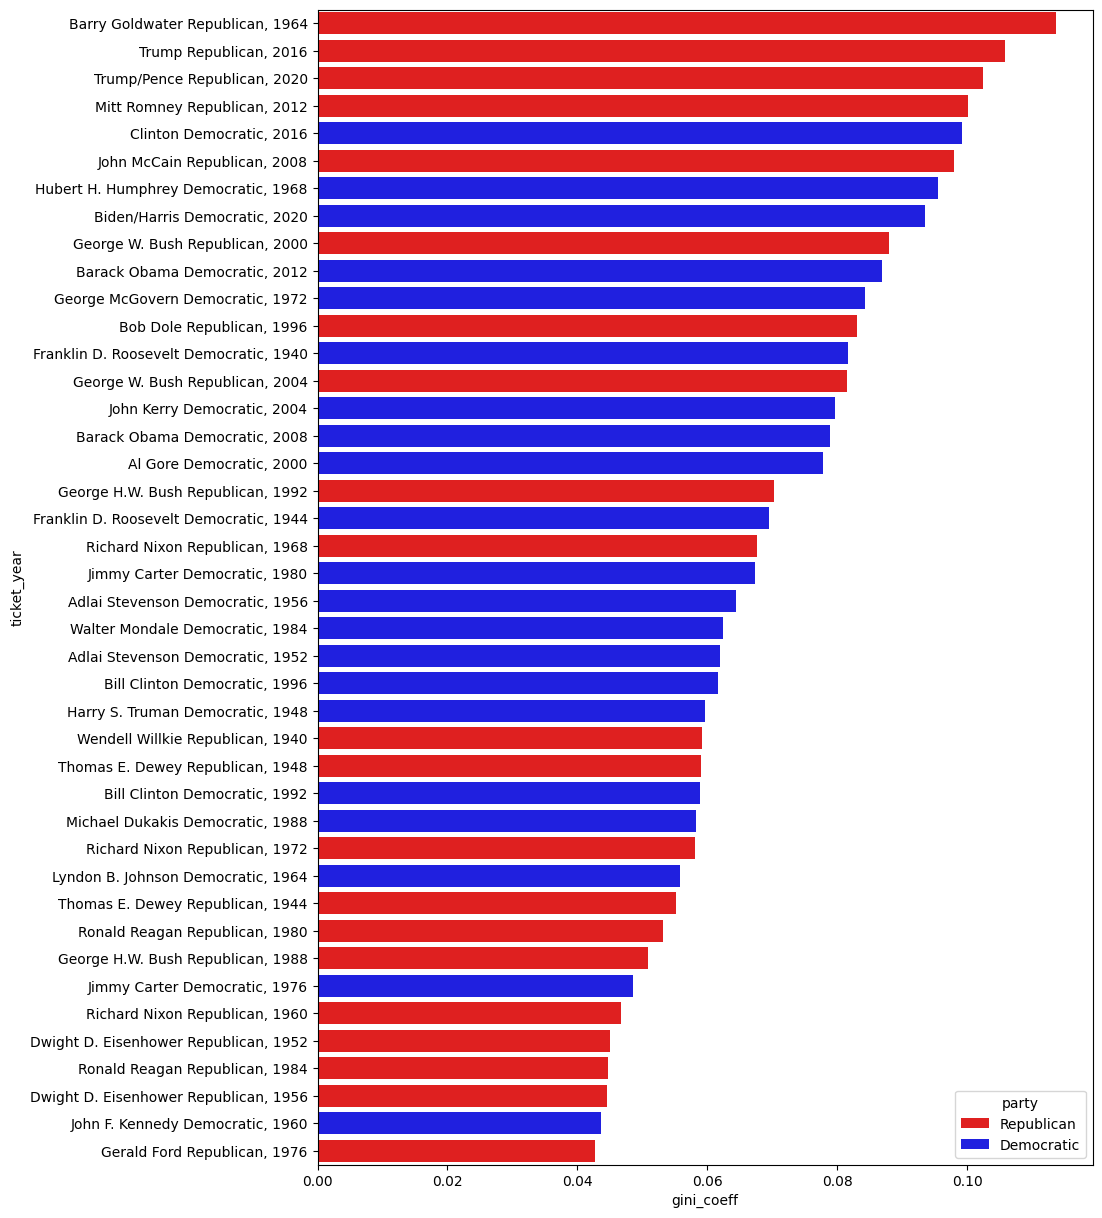

In [24]:
fig, ax = plt.subplots(figsize=(10, 15))

sns.barplot(data=candidate_gini_scores_df[(candidate_gini_scores_df["rank"]<=2) 
                                          & (candidate_gini_scores_df["election_year"] >= 1940)]\
                                              .sort_values("gini_coeff", ascending=False),
            x="gini_coeff",
            y="ticket_year",
            hue="party",
            palette={"Democratic":"b", "Republican":"r"}
            )

In [25]:
candidates = [
    {"candidate":"Barry Goldwater Republican", "election":1964}, 
    {"candidate":"Trump Republican", "election":2016}, 
    {"candidate":"Barack Obama Democratic", "election":2008},
    {"candidate":"John F. Kennedy Democratic", "election":1960},
    {"candidate":"Ronald Reagan Republican", "election":1984},
    {"candidate":"Richard Nixon Republican", "election":1972},
    ]

hist_df = pd.DataFrame()

for candidate in candidates:
    candidate_df = elections_df[(elections_df["ticket"]==candidate["candidate"]) 
                                            & (elections_df["election_year"]==candidate["election"])]
    hist_df = pd.concat([hist_df, candidate_df])

hist_df["ticket"].unique()

array(['Barry Goldwater Republican', 'Trump Republican',
       'Barack Obama Democratic', 'John F. Kennedy Democratic',
       'Ronald Reagan Republican', 'Richard Nixon Republican'],
      dtype=object)

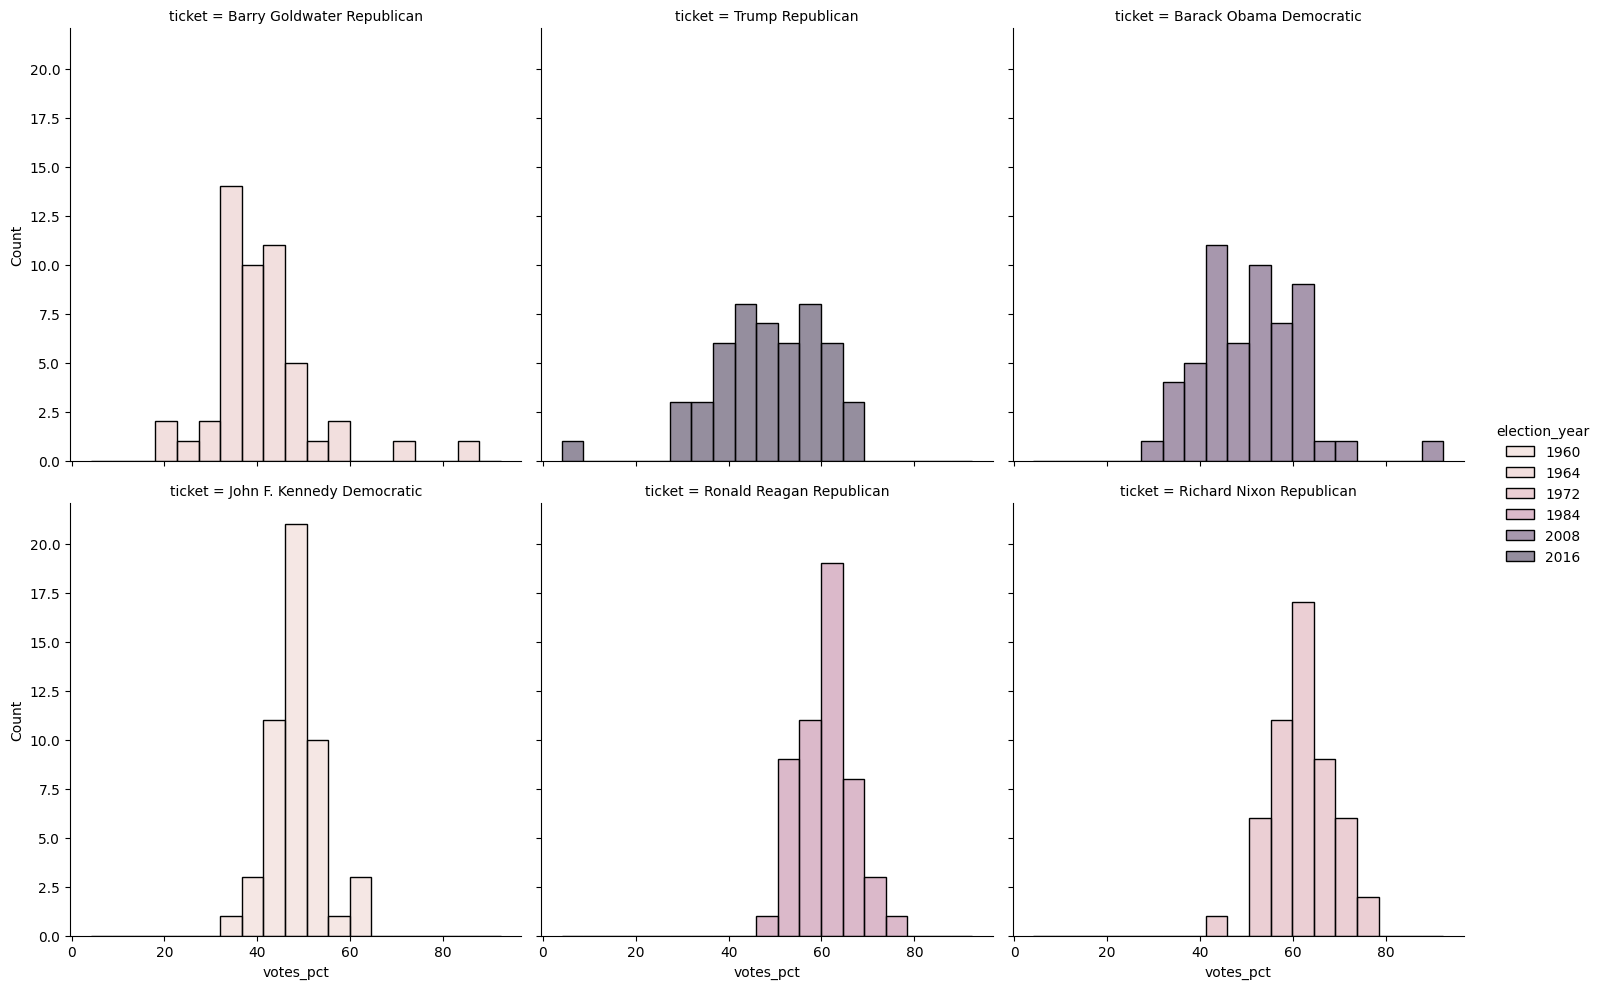

In [26]:
sns.displot(data=hist_df, kind="hist", col_wrap=3, col="ticket", x="votes_pct", hue="election_year")

#### By election

In [27]:
gini_by_election = calculator.gini_coeff_by_election(candidate_gini_scores_df)

In [28]:
gini_by_election["gini_coeff_sma"] = gini_by_election["gini_coeff"].rolling(5, min_periods=1).mean()

In [29]:
gini_by_election = gini_by_election.melt(id_vars="election_year", var_name="variable", value_name="value")

<Axes: xlabel='election_year', ylabel='value'>

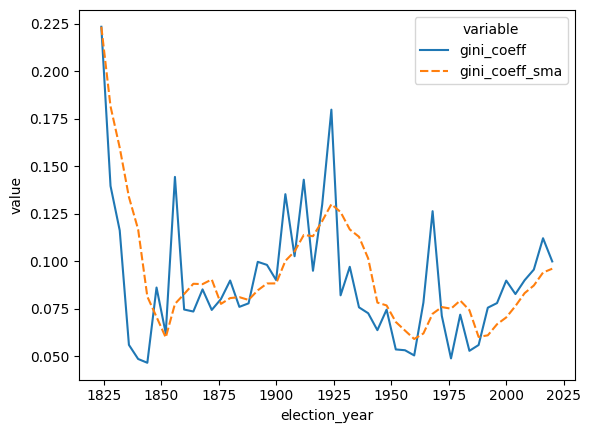

In [30]:
sns.lineplot(data=gini_by_election,
             x="election_year",
             y="value",
             hue="variable",
             style="variable"
             )

In [31]:
gini_by_election.loc[gini_by_election["variable"]=="gini_coeff_sma", ["election_year", "value"]].sort_values("value", ascending=False).head(20)

,election_year,value
50,1824,0.223434
51,1828,0.181528
52,1832,0.159743
53,1836,0.133789
75,1924,0.130009
76,1928,0.125889
74,1920,0.121108
54,1840,0.116733
77,1932,0.116717
72,1912,0.113786
